<a href="https://colab.research.google.com/github/ItsAkilesh/securechirp_kavach/blob/main/RESNET_FineTuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import os
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
PATH = "/content/drive/MyDrive/Split_Data"

train_dir = os.path.join(PATH, 'train')
val_dir = os.path.join(PATH, 'val')

BATCH_SIZE = 16
IMG_SIZE = (160, 160)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

Found 4883 files belonging to 2 classes.


In [ ]:
# test_dataset = tf.keras.utils.image_dataset_from_directory(test_dir,
#                                                             shuffle=True,
#                                                             batch_size=BATCH_SIZE,
#                                                             image_size=IMG_SIZE)

In [ ]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(val_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 1222 files belonging to 2 classes.


In [ ]:
class_names = ['Non Nude', "nude"]
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
 data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
  tf.keras.layers.RandomZoom(height_factor=(0.2, 0.3)),
])


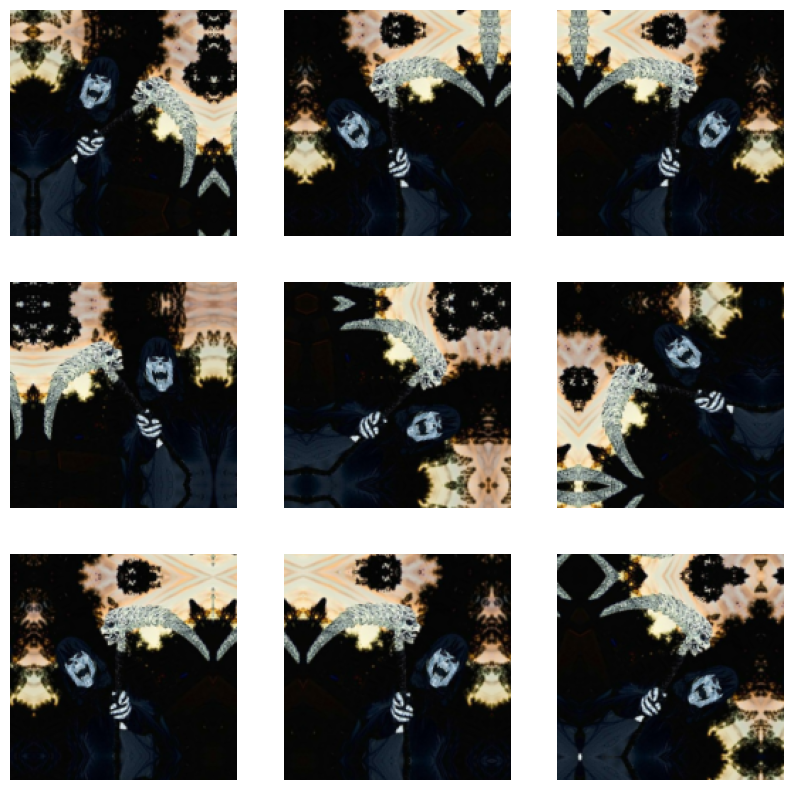

In [ ]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [ ]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [ ]:
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

In [ ]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [ ]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(16, 5, 5, 1280)


In [ ]:
base_model.trainable = True

In [ ]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(16, 1280)


In [ ]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(16, 1)


In [ ]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                             

In [ ]:
len(model.trainable_variables)

158

In [ ]:
initial_epochs = 7

loss0, accuracy0 = model.evaluate(validation_dataset)

77/77 [==============================] - 5s 34ms/step - loss: 0.8482 - accuracy: 0.4574


In [ ]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.85
initial accuracy: 0.46


In [ ]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/7
306/306 [==============================] - 56s 75ms/step - loss: 0.4229 - accuracy: 0.7989 - val_loss: 0.2747 - val_accuracy: 0.9034
Epoch 2/7
306/306 [==============================] - 23s 73ms/step - loss: 0.3328 - accuracy: 0.8587 - val_loss: 0.3514 - val_accuracy: 0.8437
Epoch 3/7
306/306 [==============================] - 23s 76ms/step - loss: 0.2751 - accuracy: 0.8837 - val_loss: 0.2532 - val_accuracy: 0.9075
Epoch 4/7
306/306 [==============================] - 23s 75ms/step - loss: 0.2393 - accuracy: 0.8978 - val_loss: 0.2594 - val_accuracy: 0.8969
Epoch 5/7
306/306 [==============================] - 23s 74ms/step - loss: 0.2152 - accuracy: 0.9119 - val_loss: 0.3578 - val_accuracy: 0.8437
Epoch 6/7
306/306 [==============================] - 23s 75ms/step - loss: 0.1995 - accuracy: 0.9173 - val_loss: 0.3250 - val_accuracy: 0.8265
Epoch 7/7
306/306 [==============================] - 25s 80ms/step - loss: 0.1730 - accuracy: 0.9316 - val_loss: 0.2522 - val_accuracy: 0.9002

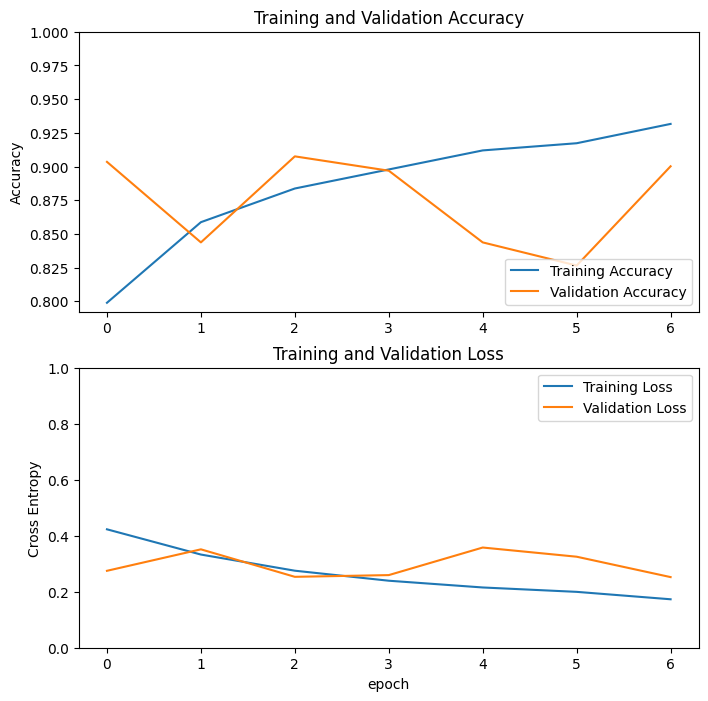

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
model.save("FeatureExtraction_model2.h5")

FIne Tuning

In [ ]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  154


In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                             

In [ ]:
len(model.trainable_variables)

56

In [ ]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 7/17
306/306 [==============================] - 27s 52ms/step - loss: 0.1394 - accuracy: 0.9453 - val_loss: 0.5825 - val_accuracy: 0.8101
Epoch 8/17
306/306 [==============================] - 16s 50ms/step - loss: 0.1229 - accuracy: 0.9535 - val_loss: 0.6792 - val_accuracy: 0.7848
Epoch 9/17
306/306 [==============================] - 15s 50ms/step - loss: 0.1118 - accuracy: 0.9562 - val_loss: 0.6861 - val_accuracy: 0.8003
Epoch 10/17
306/306 [==============================] - 15s 49ms/step - loss: 0.1077 - accuracy: 0.9576 - val_loss: 0.7769 - val_accuracy: 0.7889
Epoch 11/17
306/306 [==============================] - 15s 50ms/step - loss: 0.1064 - accuracy: 0.9588 - val_loss: 0.8133 - val_accuracy: 0.7921
Epoch 12/17
306/306 [==============================] - 15s 50ms/step - loss: 0.1051 - accuracy: 0.9601 - val_loss: 0.8813 - val_accuracy: 0.7709
Epoch 13/17
306/306 [==============================] - 16s 51ms/step - loss: 0.0957 - accuracy: 0.9633 - val_loss: 0.7146 - val_accur

In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
loss, accuracy = model.evaluate(validation_dataset)
print('Test accuracy :', accuracy)

77/77 [==============================] - 4s 43ms/step - loss: 1.1700 - accuracy: 0.7619
Test accuracy : 0.7618657946586609


In [ ]:
# Retrieve a batch of images from the test set
image_batch, label_batch = validation_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

In [ ]:
model.save("FineTuning_model2.h5")